In [1]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn.functional as F
import re

from nltk.tokenize import word_tokenize
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from tqdm import tqdm
from tqdm.auto import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
def alphanumeric_cleansing(text):
    # Remove non-alphanumeric characters using regular expression
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text

In [4]:
# Alphanumeric Cleansing
df = pd.read_csv('./brown.csv')
df['tokenized_text'] = df['tokenized_text'].apply(lambda row: alphanumeric_cleansing(row))
df['tokens'] = df['tokenized_text'].apply(word_tokenize)

In [5]:
# Merge rare words
all_tokens = [token for sublist in df['tokens'] for token in sublist]
token_freq = Counter(all_tokens)
df['tokens'] = df['tokens'].apply(lambda tokens: ['UNKNOWN' if token_freq[token]<=3 else token for token in tokens])
df['processed_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

In [6]:
df

,filename,para_id,sent_id,raw_text,tokenized_text,tokenized_pos,label,tokens,processed_text
0,cd05,0,0,"Furthermore/rb ,/, as/cs an/at encouragement/n...",Furthermore as an encouragement to revisionis...,"rb , cs at nn in nn nn , pps rb bez jj to vb c...",religion,"[Furthermore, as, an, encouragement, to, UNKNO...",Furthermore as an encouragement to UNKNOWN thi...
1,cd05,0,1,The/at Unitarian/jj clergy/nns were/bed an/at ...,The Unitarian clergy were an exclusive club of...,at jj nns bed at jj nn in vbn nns -- cs at nn ...,religion,"[The, Unitarian, clergy, were, an, exclusive, ...",The Unitarian clergy were an exclusive club of...
2,cd05,0,2,"Ezra/np Stiles/np Gannett/np ,/, an/at honorab...",Ezra Stiles Gannett an honorable representati...,"np np np , at jj nn in at nn , vbd ppl rb in a...",religion,"[UNKNOWN, UNKNOWN, UNKNOWN, an, honorable, rep...",UNKNOWN UNKNOWN UNKNOWN an honorable represent...
3,cd05,0,3,"Even/rb so/rb ,/, Gannett/np judiciously/rb ar...",Even so Gannett judiciously argued the Assoc...,"rb rb , np rb vbd , at nn-tl md rb vb cs np ``...",religion,"[Even, so, UNKNOWN, UNKNOWN, argued, the, Asso...",Even so UNKNOWN UNKNOWN argued the Association...
4,cd05,0,4,We/ppss today/nr are/ber not/* entitled/vbn to...,We today are not entitled to excoriate honest ...,ppss nr ber * vbn to vb jj nns wps vbd np to b...,religion,"[We, today, are, not, entitled, to, UNKNOWN, h...",We today are not entitled to UNKNOWN honest me...
...,...,...,...,...,...,...,...,...,...
57335,cj14,6,3,"For/in the/at most/ap part/nn ,/, this/dt disc...",For the most part this discussion will be con...,"in at ap nn , dt nn md be vbn in nns vbn in at...",learned,"[For, the, most, part, this, discussion, will,...",For the most part this discussion will be conf...
57336,cj14,6,4,A/np-hl ./.-hl,A,np-hl .-hl,learned,[A],A
57337,cj14,6,5,Standard/jj-hl preparations/nns-hl and/cc-hl u...,Standard preparations and units of thyroidstim...,jj-hl nns-hl cc-hl nns-hl in-hl jj-hl nn-hl,learned,"[Standard, preparations, and, units, of, thyro...",Standard preparations and units of thyroidstim...
57338,cj14,6,6,The/at international/jj unit/nn (/( u./nn )/) ...,The international unit u adopted to make po...,"at jj nn ( nn ) , vbn to vb jj at nn in nns in...",learned,"[The, international, unit, UNKNOWN, adopted, t...",The international unit UNKNOWN adopted to make...


In [7]:
tokens = {token for sublist in df['tokens'] for token in sublist}
sorted_tokens = sorted(tokens)
vocab = {token: idx for idx, token in enumerate(sorted_tokens)}
token_to_word = {v: k for k, v in vocab.items()}

In [8]:
counter = 0
flag = 0
train_sep = -1
val_sep = -1
for index, row in df.iterrows():
    counter += len(row.tokens)
    if counter >= 800000 and flag == 0:
        train_sep = index
        counter = 0
        flag = 1
        continue
    if counter >= 200000 and flag == 1:
        val_sep = index
        break

train_df = df.iloc[:train_sep] 
val_df = df.iloc[train_sep+1:val_sep]
test_df = df.iloc[val_sep+1:]

In [9]:
# A short note here that n in the paper is not the same as the n-gram. But instead n_gram = n - 1
# So given n = 5, the prediction will use 4-gram instead.

def generate_n_gram(text, n_gram):
        words = word_tokenize(text)
        n_grams = zip(*[words[i:] for i in range(n_gram)])
        n_grams = [" ".join(i) for i in n_grams]
        if n_grams:
            n_grams.pop()
        n_grams = [(n_grams[i], words[i+n_gram]) for i in range(len(n_grams))]
        return list(n_grams)
    
class CustomTextDataset(Dataset):
    def __init__(self, n, df, vocab):
        self.n = n
        self.n_gram = n - 1
        self.vocab = vocab
        self.V = len(vocab)
        temp_df = df['processed_text'].apply(lambda row: generate_n_gram(row, self.n_gram))
        self.data = []
        for index, row in temp_df.items():
            if row:
                self.data += row 
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        ngram, next_word = self.data[idx]
        ngram_indices = [self.vocab[word] for word in word_tokenize(ngram)]
        next_word_index = self.vocab[next_word]
        ngram_indices_tensor = torch.tensor(ngram_indices).to(device)
        next_word_index_tensor = torch.tensor(next_word_index).to(device)
        return ngram_indices_tensor, next_word_index_tensor

In [10]:
train_set = CustomTextDataset(5, train_df, vocab)
val_set = CustomTextDataset(5, val_df, vocab)
test_set = CustomTextDataset(5, test_df,vocab)

trainloader = DataLoader(train_set, batch_size=4096)
valloader = DataLoader(val_set, batch_size=4096)
testloader = DataLoader(test_set, batch_size=4096)

In [13]:
class NeuralNetLM(nn.Module):
    def __init__(self, vocab, m, n, h):
        super().__init__()
        self.vocab = vocab
        self.h = h
        self.n = n
        self.m = m
        self.V = len(vocab)
        self.C = nn.Embedding(self.V, self.m)
        self.H = nn.Parameter(torch.randn(self.h, (self.n-1) * self.m))
        self.d = nn.Parameter(torch.randn(self.h, 1))
        self.U = nn.Parameter(torch.randn(self.V, self.h))
        self.W = nn.Parameter(torch.randn(self.V, (self.n-1) * self.m))
        self.b = nn.Parameter(torch.randn(self.V, 1))
    
    # Batch forward
    # x has a shape of (batch_size, (n-1))
    def forward(self, x):
        x = self.C(x)
        x = x.reshape(self.m * (self.n - 1), -1) # [m*(n-1), batch_size]
        x = self.b + self.W @ x + self.U @ torch.tanh((self.H @ x) + self.d)
        x = x.T
        x = F.log_softmax(x, dim=1)
        return x

In [14]:
model = NeuralNetLM(vocab, m = 60, n = 5, h = 50).to(device)
criterion = nn.NLLLoss() # Training is actually done with 2 loss functions, weights use L2, 
                         # Biases use max. likelihood without regularization term.
optimizer = optim.AdamW(model.parameters())

In [15]:


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode=='train':
        model.train()
    elif mode=='test':
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode=='train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

In [19]:
epochs = 20
train_cost, test_cost = [], []
for i in range(epochs):
    cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost)
    with torch.no_grad():
        cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        test_cost.append(cost)
    
    print(f"\rEpoch: {i+1}/{epochs} | train_cost: {train_cost[-1]: 4f} | test_cost: {test_cost[-1]: 4f} | ", end=" ")

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1/20 | train_cost:  38.354642 | test_cost:  39.591419 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2/20 | train_cost:  34.611660 | test_cost:  36.478985 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3/20 | train_cost:  31.471597 | test_cost:  33.785180 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4/20 | train_cost:  28.761548 | test_cost:  31.430763 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5/20 | train_cost:  26.403473 | test_cost:  29.334626 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6/20 | train_cost:  24.341675 | test_cost:  27.490616 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7/20 | train_cost:  22.530679 | test_cost:  25.865943 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8/20 | train_cost:  20.938989 | test_cost:  24.452043 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9/20 | train_cost:  19.535496 | test_cost:  23.203960 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10/20 | train_cost:  18.294440 | test_cost:  22.095610 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11/20 | train_cost:  17.193149 | test_cost:  21.112482 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12/20 | train_cost:  16.210646 | test_cost:  20.237766 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13/20 | train_cost:  15.331110 | test_cost:  19.453096 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14/20 | train_cost:  14.540216 | test_cost:  18.747457 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15/20 | train_cost:  13.825717 | test_cost:  18.109328 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16/20 | train_cost:  13.177628 | test_cost:  17.529509 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17/20 | train_cost:  12.587641 | test_cost:  17.000324 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18/20 | train_cost:  12.048539 | test_cost:  16.515399 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19/20 | train_cost:  11.554275 | test_cost:  16.070095 |  

Train:   0%|          | 0/153 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20/20 | train_cost:  11.099799 | test_cost:  15.660364 |  

# Cost History

In [20]:
import matplotlib.pyplot as plt

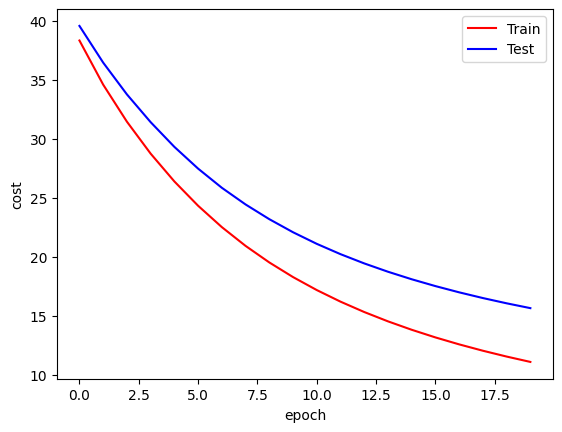

In [21]:
plt.plot(train_cost, 'r-', label='Train')
plt.plot(test_cost, 'b-', label='Test')
plt.xlabel('epoch'); plt.ylabel('cost'); plt.legend();

# Save and Load Model

In [22]:
import os
os.makedirs('model', exist_ok=True)

In [23]:
# Save Model
torch.save(model.state_dict(), 'model/weights.pth')

In [ ]:
# Load Model
model = NeuralNetLM(vocab, m = 60, n = 5, h = 50)
weights = torch.load('/kaggle/input/neuralnetlm-20epoch/pytorch/neuralnetlm-20epoch/1/weights.pth', map_location='cpu')
model.load_state_dict(weights)
model = model.to(device)

# Evaluation

For a batch, create a function that returns the inverse probability value. 
Later, concat all the values of each tensor and compute the geometric mean. 

In [ ]:
batch_sample = next(test_data_iter)

In [ ]:
a = torch.randn(2048)
b = torch.randn(2048)
torch.cat((a, b), dim=0).shape

In [26]:
# Gather inverse probability values based on the index of target. 
def gather_reciprocal_values(batch):
    feature, target = batch[0], batch[1]
    target.reshape(feature.shape[0])
    target = target.unsqueeze(1)
    result = torch.gather(model(feature), 1, target)
    result = result.squeeze()
    result = torch.exp(result) # Revert back to softmax probability values
    result = 1.0 / result # Apply multiplicative inverse element wise
    return result

inverse_probability_tensor_list = [gather_reciprocal_values(batch) for batch in testloader]
inverse_probability_values = torch.cat(inverse_probability_tensor_list, dim=0)

In [27]:
def compute_geometric_mean(inverse_probability_values):
    product = torch.prod(inverse_probability_values)
    n = inverse_probability_values.numel()
    geometric_mean_reciprocals = product ** (1.0 / n)
    return geometric_mean_reciprocals

compute_geometric_mean(inverse_probability_values)

tensor(inf, device='cuda:0', grad_fn=<PowBackward0>)

In [31]:
# Inference

def predict_next_word(text):
    tokens = word_tokenize(text)
    word_indices = torch.tensor([vocab[word] for word in tokens], device=device)
    model_output = model(word_indices)
    predicted_index = torch.argmax(torch.exp(model_output)).item()
    return token_to_word[predicted_index]


'neat'

In [1]:
initial_text = ['Well', 'I', 'am', 'sure']
gen_text_len = 50
for i in range(gen_text_len):
    text = " ".join(initial_text[-4:])
    initial_text.append(predict_next_word(text))

gen_text = ' '.join(initial_text)

NameError: name 'predict_next_word' is not defined

In [44]:
print(gen_text)

Well I am sure neat forces interference 830 Lacking concerto Parliament miracles loses Athletic consciousness threeyear f ancient beards boundaries request Roger inhabitants dreams Orient tentatively Opera occurring fondly Princes negotiation confided relish Terry fruitful collage machinery dominance scrub Iowa worlds bias phases indelible recording trips Mannings profit initiated Gospel widow grants imaginary white successes Copernicus companionship amounted Meyer Garibaldis tree sufficiently studded stripe pierced interlocking minimize currently manifestations Rite whipped chap Leader cathode poignant Pierce militia dislikes glass Merchant speedy negotiations System melt delegated favoritism prohibiting workable verb disgusted understand Oklahoma boiling 9th wider stairway grandmothers trailer sincere meantime intrigue Beginning denoting orchards
